# k-Nearest Neighbor

1) Implement the k-Nearest Neighbor algorithm with Python!
2) It should be applicable for classification and regression tasks!
3) Extend your algorithm with a weighting function (see the lecture slides)

In [33]:
!pip install numpy scikit-learn pandas

In [34]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix

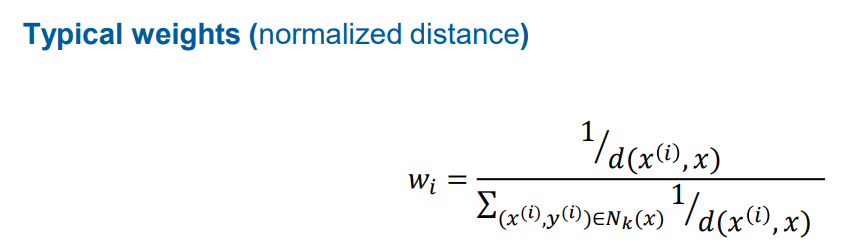

In [35]:
# # YOUR CODE HERE

# calculates the euclidean distance between 2 vectors
def euclidean_distance(x, y, axis=None):
    return np.linalg.norm(x - y, axis=axis)

def computeNeighbors(input_vector, data, k):
    neighbor_database = data.copy()

    # calculates distance between input vector and all vectors stored in dataframe in a new column
    distances = [euclidean_distance(input_vector, y) for y in neighbor_database.values[:,:-1]]
    neighbor_database["Distance"] = pd.Series(distances)

    # shortlists closest k neighbors by the previously distance calculated 
    neighbor_database = neighbor_database.sort_values(by="Distance", ascending=True).iloc[:k]

    # re-weighting neighbors by distance from input vector
    # closer the stored vector to the input vector, higher the calculated weight
    # higher the weight, more the influence over classification output
    # 
    # === SEE ABOVE FOR FORMULA ===
    #
    # 
    cumulative_weight = sum(1 / np.array(neighbor_database["Distance"]))
    neighbor_database["Weights"] = neighbor_database["Distance"].apply(lambda x: (1/x)/cumulative_weight)

    return neighbor_database

def classify(X, data, k):
    predictions = []
    
    # for each input vector to classify
    for input_vector in X:
        # calculate k closest neighbors to input vector
        neighbor_db = computeNeighbors(input_vector, data, k)
        
        # initialize zero vector which will store class probabilities
        probabilities = np.array([0] * len(np.unique(data[data.columns[-1]]))).astype(np.float32)
        
        # for each closest neighbour, add its weight to corresponding class index in probabilities vector
        for row in neighbor_db.values[:,-3:]:
            probabilities[int(row[0])] += (1 * row[2])
        predictions.append(np.argmax(probabilities))
    return np.array(predictions)

def regressor(X, data, k):
    predictions = []
    # for each input vector
    for input_vector in X:
        # calculate k closest neighbors to input vector
        neighbor_db = computeNeighbors(input_vector, data, k)

        # calculate predicted value as the weighted sum of predicted values of neighbouring points
        neighbour_values = np.array(neighbor_db[neighbor_db.columns[-3]])
        neighbour_weights = np.array(neighbor_db["Weights"])

        predictions.append(np.sum(neighbour_values * neighbour_weights))
    return predictions

## Compare the results with the sklearn kNN algorithm

In [36]:
# Make your code work with the following inputs:
# Use this data as your reference data points and labels

# Classification data
cl_X = np.arange(0, 9).reshape(9,1)
cl_y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
# print('Classification input:\n', X, '\tShape:', cl_X.shape)
# print('Classification labels:\n', y, '\tShape:', cl_y.shape)


# Regression data
r_X = np.array([[1, 2], [2, 4], [3, 6], [4, 8], [5, 10]])
r_y = np.array([1, 2, 3, 4, 5])
# print('Regression input:\n', r_X, '\tShape:', r_X.shape)
# print('Regression labels:\n', r_y, '\tShape:', r_y.shape)


# Use the following list to test your code for classification
cl_X_test = np.array([[2.1], [5.2], [7.2]])

r_X_test = np.array([[2.1, 5.1], [2.6, 6.2]])

In [37]:
# classification (dont forget the weighting function)

# yours
predicted_classes = classify(cl_X_test, pd.DataFrame(np.append(cl_X, cl_y.reshape(-1,1), axis=1)), 3)

# sklearn comparison
model = KNeighborsClassifier(n_neighbors=3, metric="euclidean").fit(cl_X, cl_y)
actual_classes = model.predict(cl_X_test)

print(f"Accuracy: {accuracy_score(predicted_classes, actual_classes) * 100}%")

Accuracy: 100.0%


In [38]:
# regression (dont forget the weighting function)

# yours
predicted_values = regressor(r_X_test, pd.DataFrame(np.append(r_X, r_y.reshape(-1,1), axis=1)), 3)

# sklearn comparison
model = KNeighborsRegressor(n_neighbors=3, metric="euclidean").fit(r_X, r_y)
actual_values = model.predict(r_X_test)

print(f"RMSE: {np.sqrt(mean_squared_error(predicted_values, actual_values))}")

RMSE: 0.17071771037042754


In [39]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add scatter traces for training points, KNN predictions, and sklearn predictions
fig.add_trace(go.Scatter3d(x=r_X[:, 0], y=r_X[:, 1], z=r_y, mode='markers', name='Training Data', marker=dict(color='blue')))
fig.add_trace(go.Scatter3d(x=r_X_test[:, 0], y=r_X_test[:, 1], z=predicted_values, mode='markers', name='KNN Predictions', marker=dict(color='red')))
fig.add_trace(go.Scatter3d(x=r_X_test[:, 0], y=r_X_test[:, 1], z=actual_values, mode='markers', name='Sklearn Predictions', marker=dict(color='green', symbol='cross')))

# Update layout
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Predicted Value'),
                  title='Interactive 3D Plot: Regression - Training and Predictions')

# Show plot
fig.show()
